In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
URL = "https://raw.githubusercontent.com/avehtari/casestudies/master/Birthdays/data/births_usa_1969.csv"
data = pd.read_csv(URL)
data.head()

year  month  day  births  day_of_year  day_of_week  id  day_of_year2
0  1969      1    1    8486            1            3   1             1
1  1969      1    2    9002            2            4   2             2
2  1969      1    3    9542            3            5   3             3
3  1969      1    4    8960            4            6   4             4
4  1969      1    5    8390            5            7   5             5

In [4]:
day_zero = pd.to_datetime("1968-12-31")
data["date"] = [day_zero + pd.Timedelta(n + 1, unit="day") for n in range(len(data))]
data["births_relative100"] = data["births"] / data["births"].mean() * 100
data

year  month  day  births  day_of_year  day_of_week    id  day_of_year2  \
0     1969      1    1    8486            1            3     1             1   
1     1969      1    2    9002            2            4     2             2   
2     1969      1    3    9542            3            5     3             3   
3     1969      1    4    8960            4            6     4             4   
4     1969      1    5    8390            5            7     5             5   
...    ...    ...  ...     ...          ...          ...   ...           ...   
7300  1988     12   27   11528          362            2  7301           362   
7301  1988     12   28   11847          363            3  7302           363   
7302  1988     12   29   11704          364            4  7303           364   
7303  1988     12   30   11837          365            5  7304           365   
7304  1988     12   31    9133          366            6  7305           366   

           date  births_relative100  
0    1969-01-01           87.947483  
1    1969-01-02           93.295220  
2    1969-01-03           98.891690  
3    1969-01-04           92.859939  
4    1969-01-05           86.952555  
...         ...                 ...  
7300 1988-12-27          119.474261  
7301 1988-12-28          122.780324  
7302 1988-12-29          121.298296  
7303 1988-12-30          122.676686  
7304 1988-12-31           94.652882  

[7305 rows x 10 columns]

## Plot all births

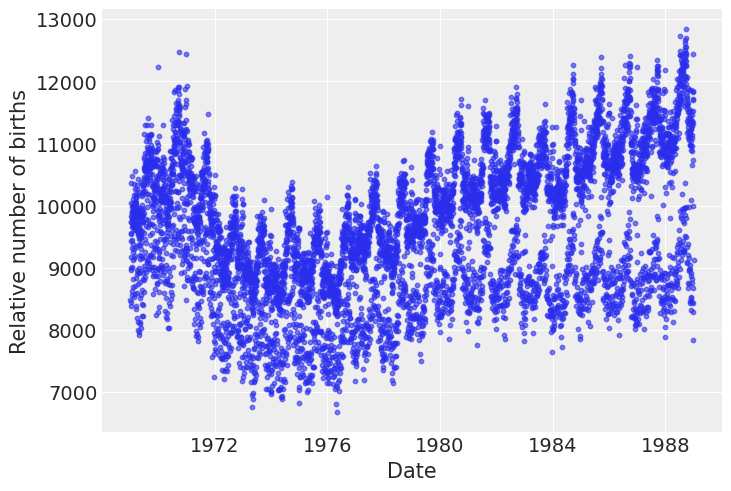

In [5]:
plt.scatter("date", "births", s=10, alpha=0.6, data=data)
plt.xlabel("Date")
plt.ylabel("Relative number of births");

## Plot all births as relative to mean

To make the interpretation we switch to examine the relative change, with the mean level denoted with 100.

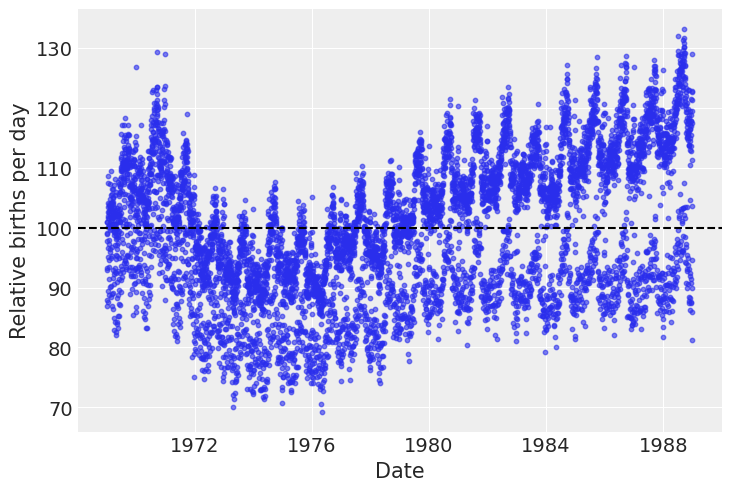

In [6]:
plt.scatter("date", "births_relative100", s=10, alpha=0.6, data=data)
plt.axhline(100, color="k", ls="--")
plt.xlabel("Date")
plt.ylabel("Relative births per day");

## Plot mean per day of year

We can see the generic pattern in yearly seasonal trend simply by averaging over each day of year (day_of_year has numbers from 1 to 366 every year with leap day being 60 and 1st March 61 also on non-leap-years).

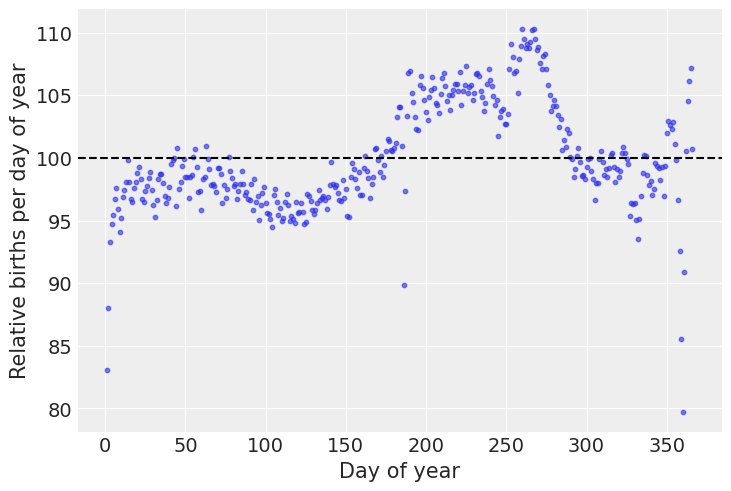

In [7]:
d = data.groupby("day_of_year2").agg(meanbirths = ("births_relative100", "mean")).reset_index()

plt.scatter("day_of_year2", "meanbirths", s=10, alpha=0.6, data=d)
plt.axhline(100, color="k", ls="--")
plt.xlabel("Day of year")
plt.ylabel("Relative births per day of year");

## Plot mean per day of week

We can see the generic pattern in weekly trend simply by averaging over each day of week.



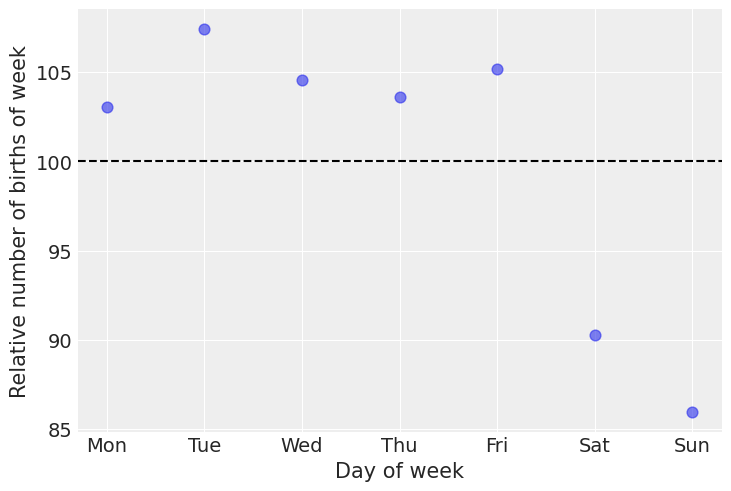

In [8]:
d = data.groupby("day_of_week").agg(meanbirths = ("births_relative100", "mean")).reset_index()

_, ax = plt.subplots()

ax.scatter("day_of_week", "meanbirths", s=60, alpha=0.6, data=d)
ax.axhline(100, color="k", ls="--")
ax.set_xlabel("Day of week")
ax.set_ylabel("Relative number of births of week");
ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]);

## Utilities

In [9]:
class Transformer:
    """
    f: The transformation
    g: The inverse of the transformation
    """
    def __init__(self, f, g):
        self.f = f
        self.g = g
    
    def transform(self, x):
        return self.f(x)
    
    def inverse(self, x):
        return self.g(x)


class Scaler:
    """
    Standardizes the data to have mean 0 and sd 1.
    """
    def __init__(self, transform=None):
        self.transform = transform
    
    def fit(self, x):
        if self.transform:
            x = self.transform.transform(x)
        self.mean = np.mean(x)
        self.std = np.std(x)
        return self
   
    def scale(self, x):
        if self.transform:
            x = self.transform.transform(x)
        return (x - self.mean) / self.std
    
    def unscale(self, x):
        x = x * self.std + self.mean
        if self.transform:
            x = self.transform.inverse(x)
        return x

## Hilbert spaces approximation to Gaussian Processes (HSGP)


The squared exponential kernel

$$
k(r) = \alpha\exp\left(-\frac{1}{2}\frac{r^2}{\ell^2}\right)
$$

where $r$ is the distance between two observations, such as the Euclidean

$$
r = |\mathbf{x} - \mathbf{x'}|_{L2} = \sqrt{\sum_{i=1}^{D}\left(x_i - x_i'\right)^2}
$$

The spectral density function for the squared exponential kernel:

$$
S(\omega) = \alpha\left(\sqrt{2\pi}\right)\ell\exp\left(-\ell^2\omega^2/2\right)
$$


GPs with just a single covariate such that $\Omega \in [-L, L] \subset \mathbb{R}$, where $L$ is some positive real number we call **boundary condition**. As $\Omega$ describes the interval in which the approximations are valid, $L$ plays a critical role in the accuracy of this method.

Within $\Omega$, we can write any stationary covariance function with input values $\left\{x, x' \right\} \in \Omega$ as

$$
k(x, x') = \sum_{j = 1}^{\infty}{S_{\theta}(\sqrt{\lambda_j}) \phi_j(x) \phi_j(x')}
$$

* $S_{\theta}$ is the **spectral density** of the stationary covariance function $k$.
    + $\theta$ is the set of hyperparemeters of $k$ (e.g. $\ell$ and $\sigma$ in double exponential).
* $\left\{\lambda_j\right\}_{j=1}^{\infty}$ is the set of eigenvalues of the Laplacian operator in the domain $\Omega$.
* $\left\{\phi_j(x)\right\}_{j=1}^{\infty}$ is the set of eigenvectors of the Laplacian operator in the domain $\Omega$.


The last two satisfy the following eigenvalue problem in $\Omega$ when applying the Dirichlet boundary condition:


$$
\begin{array}{cr}
-\nabla^2 \phi_j(x) = \lambda\phi_j(x), & x \in \Omega \\
\phi_j(x) = 0, & x \notin \Omega
\end{array}
$$

$$
\begin{aligned}
\lambda_j &= \left(\frac{j\pi}{2L} \right)^2, \\
\phi_j(x) &= \sqrt{\frac{1}{L}} \sin\left(\sqrt{\lambda_j}(x + L)\right)
\end{aligned}
$$

If we truncate the infinite sum on the first equation on top to the first $m$ terms, the **approximate covariance function** becomes

$$
k(x, x') \approx \sum_{j=1}^{m}S_{\theta}(\sqrt{\lambda_j}) \phi_j(x) \phi_j(x') = \mathbf{\phi(x)^T}\Delta\mathbf{\phi(x')}
$$

where $\mathbf{\phi(x)} = \left\{\phi_j(x)\right\}_{j=1}^m \in	\mathbb{R}^m$ is the column vector of basis functions, and $\Delta \in \mathbb{R}^{m \times n}$ is a **diagonal matrix of the spectral density evaluated at the square root of the eigenvalues**, that is, $S_{\theta}(\sqrt{\lambda_j})$


$$
\Delta = 
\begin{bmatrix}
S_{\theta}(\sqrt{\lambda_1}) &  & \\
 & \ddots & \\
 & & S_{\theta}(\sqrt{\lambda_m})
\end{bmatrix}
$$

Thus, the Gram matrix $K$ of the covariance function $k$ for a set of observations $i = 1, \cdots, n$ and corresponding input values $\left\{x_i \right\}_{i=1}^{n} \in \Omega^n$ can be represented as

$$ 
\mathbf{K} = \Phi \Delta \Phi^{T}
$$

where $\Phi \in \mathbb{R}^{n \times m}$ is the matrix of eigenfunctions $\phi_j(x_i)$ 

$$
\Phi = 
\begin{bmatrix}
\phi_1(x_1) & \cdots  & \phi_m(x_1) \\
 \vdots & \ddots & \vdots \\
\phi_1(x_n) & \cdots  & \phi_m(x_n)
\end{bmatrix}
$$

As a result, the model for $f$ can be written as 

$$
\mathbf{f} \sim \text{Normal}(\mathbf{\mu}, \Phi \Delta \Phi^T)
$$

This equivalently leads to a linear representation of $f$ via

$$
f(x) \approx \displaystyle \sum_{j=1}^{m}{\left(S_{\theta}(\sqrt{\lambda_j})\right)^{\frac{1}{2}}} \phi_j(x) \beta_j
$$

where $\beta_j \sim \text{Normal}(0, 1)$. 

Thus, the function $f$ is approximated with a finite basis function expansion (using the eigenfunctions $\phi_j$ of the Laplace operator), scaled by the square root of spectral density values.

A key property of this approximation is that the eigenfunctions $\phi_j$ do not depend on the hypermarameters of the covariance function $\theta$. The only dependence of the model on $\theta$ is through the spectral density $S_{\theta}$.

The eigenvalues $\lambda_j$ are monotonically increasing with $j$ and $S_\theta$ goes rapidly to zero for bounded covariance functions. The last equation can be expected to be a good approximation for a finite number of $m$ terms in the series as long as the inputs values $x_i$ are not too close to the boundaries $-L$ and $L$ of $\Omega$.

The posterior distribution of the parameters $p(\beta|y)$ is a distribution over a $m$-dimensional space, where $m$ is much smaller than the number of observations $n$.


In [10]:
class SquaredExponential:
    """
    alpha: Theano variable (aka sigma)
    length: Theano variable (aka ell)
    m: The number of basis functions to keep
    L: The boundary condition
    """
    def __init__(self, alpha, length, m, L):
        self.alpha = alpha
        self.length = length
        self.m = m
        self.L = L

    def spectral_density(self, w):
        # This is S(w) above
        c = self.alpha * np.sqrt(2 * np.pi) * self.length
        e = tt.exp(-0.5 * (self.length ** 2) * (w ** 2))
        return c * e
    
    def Delta(self):
        # Get the square root of the eigenvalues
        j = np.arange(1, 1 + self.m)
        sqrt_eigenvalues = (j * np.pi) / (2 * self.L)
        
        # Compute sqrt of the spectral density of the sqrt(lambda)       
        return self.spectral_density(sqrt_eigenvalues)
    
    def Phi(self, x):
        """
        The first `m` eigenfunctions of the Laplacian operater in `[-L, L]` 
        evaluated at `x`. These are used for the approximation of the squared
        exponential kernel
        """
        m1 = (np.pi / (2 * self.L)) * np.tile(self.L + x[:, None], self.m)
        m2 = np.diag(np.linspace(1, self.m, num=self.m))
        num = np.sin(m1 @ m2)
        den = np.sqrt(self.L)
        return num / den
    
    def get_basis(self, name, x):
        beta = pm.Normal(f"β_{name}", mu=0, sigma=1, shape=self.m)
        Phi = self.Phi(x)
        Delta = self.Delta()
        f = pm.Deterministic(name, tt.dot(Phi, Delta * beta))
        return f

A GP model with a periodic covariance function does no fit in the framework of the HSGP approximation covered in Aki's paper, but it has also a low-rank representation. This following is a presentation of work done by Solin and Sarkka (2014), who obtain an approximate linear representation of a periodic squared exponential covariance function based on expanding the periodic covariance function into a series of stochastic resonators.

The periodic squared exponential covariance function takes the form

$$
k(\mathbf{\tau}) = \alpha \exp\left(-\frac{2\sin^2(\omega_0 \frac{\mathbf{\tau}}{2})}{\ell^2} \right)
$$

where $\alpha$ is the magnitude scale of the covariance, $\ell$ is the characteristic lengthscale of the covariance, and $\omega_0$ is the angular frequency defining the periodicity.

Solin and Sarkka (2014) derive a cosine series expansion for the periodic covariance function as follows,

$$
k(\tau) = \alpha \sum_{j=0}^{J}{\tilde{q}_j^2\cos\left(j\omega_0\tau\right)}
$$


An upper bounded approximation to the coefficients $\tilde{q}_j^2$ and $\tilde{q}_0^2$ can be obtained. This leads to the following variance coefficients:

$$
\tilde{q}_j^2 = \frac{2\text{I}_j(\ell^{-2})}{\exp\left(\frac{1}{\ell^2}\right)}
$$

$$
\tilde{q}_0^2 = \frac{\text{I}_0(\ell^{-2})}{\exp\left(\frac{1}{\ell^2}\right)}
$$

for $j = 1, 2, \cdots, J$, and where $\text{I}_j(z)$ is the modified Bessel function of the first kind. 

$$
k(x, x') \approx 
\alpha \left(
    \sum_{j = 0}^{J}{\tilde{q}^2_j\cos\left(j\omega_0x\right)\cos\left(j\omega_0x'\right)} +
    \sum_{j = 1}^{J}{\tilde{q}^2_j\sin\left(j\omega_0x\right)\sin\left(j\omega_0x'\right)}
\right)
$$

With this approximation for the periodic squared exponential covariance function $k(x, x')$, the approximate GP model $f(x) \sim \text{GP}(0, k(x, x'))$ equivalently leads to a linear representation of $f(\cdot)$ via

$$
f(x) \approx 
\alpha^{1/2} \left(
    \sum_{j = 0}^{J}{\tilde{q}^2_j\cos\left(j\omega_0x\right)\beta_j} +
    \sum_{j = 1}^{J}{\tilde{q}^2_j\sin\left(j\omega_0x\right)\beta_{J+1+j}}
\right)
$$

where $\beta_j \sim \text{Normal}(0, 1)$, with $j = 1, \cdots, 2J+1$. The cosine $\cos\left(j\omega_0x\right)$ and the sinus $\sin\left(j\omega_0x\right)$ terms do not depend on the covariance hyperparameters $\ell$. The only dependence of the hyperparameter $\ell$ is through the coefficients $\tilde{q}_j$, which are $J$-dimensional.

In [11]:
from theano.scalar import iv

iv = tt.elemwise.Elemwise(iv)

def ive(v, z):
    return iv(v, z) * tt.exp(-tt.abs_(z))

def modified_bessel_first_kind(v, z):
    """
    Parameters
    ----------
    v : array_like of float
        Order.
    z : array_like of float or complex
        Argument. 
    """
    return tt.exp(tt.abs_(z)) * ive(v, z)

class PeriodicSquaredExponential:
    
    def __init__(self, alpha, length, m, L, w0):
        self.alpha = alpha
        self.length = length
        self.m = m
        self.L = L
        self.w0 = w0

    def spectral_density(self):
        """
        Not actually a spectral density but these are used in the same
        way. These are simply the first `M` coefficients of the Taylor
        expansion approximation for the periodic kernel.
        """
        a = self.length ** (-2)
        J = np.arange(1, self.m + 1)
        q2 = (2 * self.alpha ** 2 / tt.exp(a)) * modified_bessel_first_kind(J, a)
        return q2
       
    def Phi(self, x):
        """
        Basis functions for the approximation of the periodic kernel.
        """
        m1 = np.tile(w0 * x[:, None], self.m)
        m2 = np.diag(np.linspace(1, self.m, num=self.m))
        mw0x = m1 @ m2
        return np.cos(mw0x), np.sin(mw0x)
    
    
    def get_basis(self, name, x):
        β_cos = pm.Normal(f"β_cos_{name}", 0, 1, shape=self.m)
        β_sin = pm.Normal(f"β_sin_{name}", 0, 1, shape=self.m)
        cos, sin = self.Phi(x)
        Delta = np.sqrt(self.spectral_density())
        f = pm.Deterministic(name, tt.dot(cos, Delta * β_cos) + tt.dot(sin, Delta * β_sin))
        return f

## Models for relative number of birthdays

### Model 1: Long term trend


Just the slow trend over the years using Hilbert space basis function approximated Gaussian process

$$
y_i \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i = f_1 \\
f_1 \sim \text{GP}(0, K_1) \\
\sigma \sim \text{HalfNormal}(0.5)
$$

where 

$$
K_1(x, x') = \sigma_1  \exp\left(-\frac{|x - x'|^2}{2\ell_1^2}\right) \\
\sigma_1 \sim \text{HalfNormal}(0.8) \\
\ell_1 \sim \text{LogNormal}(-1, 1)
$$

In [13]:
x = data["id"].values
y = data["births_relative100"].values

x_scaler = Scaler().fit(x)
y_scaler = Scaler().fit(y)

x_std = x_scaler.scale(x)
y_std = y_scaler.scale(y)

c = 1.5             # Multiplicative factor to determine boundary L
m1 = 20             # Number of basis functions to keep
L1 = c * max(x_std) # Boundary 

with pm.Model() as model_1:  
    # Long term trend
    f1_σ = pm.HalfNormal("f1_σ", sigma=0.8)
    f1_ℓ = pm.Lognormal("f1_ℓ", mu=-1, sigma=1)
    k1 = SquaredExponential(f1_σ, f1_ℓ, m1, L1)
    f1 = k1.get_basis("f1", x_std)
                          
    μ = pm.Deterministic("μ", f1)
    σ = pm.HalfNormal("σ", 0.5)
    
    pm.Normal("y", mu=μ, sigma=σ, observed=y_std)

In [14]:
with model_1:
    idata = pm.sample(target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β_f1, f1_ℓ, f1_σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.


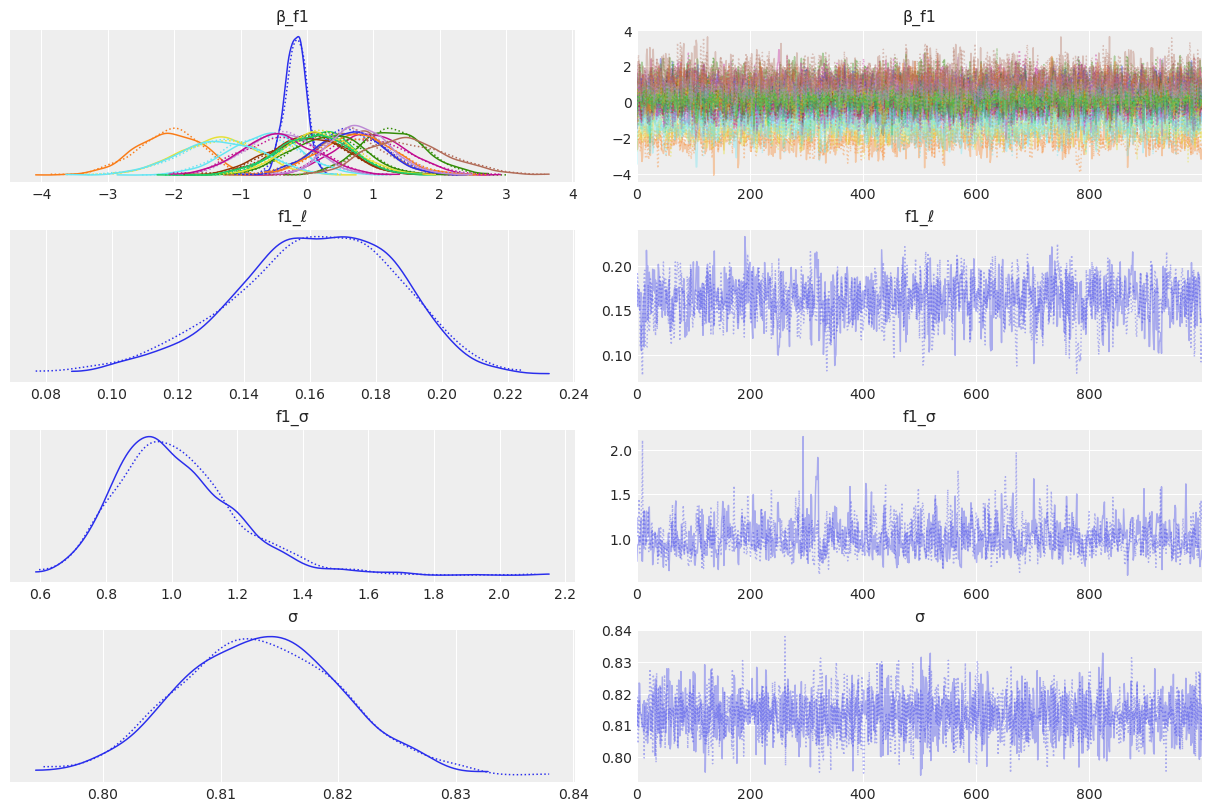

In [16]:
az.plot_trace(idata, var_names=["β_f1", "f1_ℓ", "f1_σ", "σ"]);

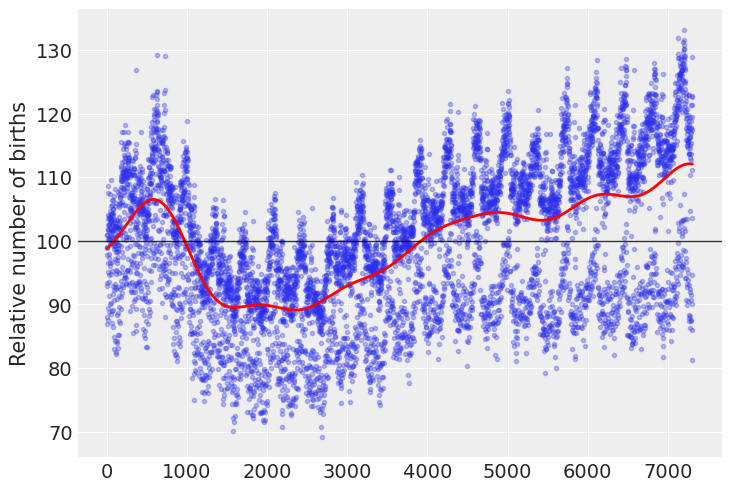

In [16]:
μ = y_scaler.unscale(idata.posterior["μ"]).mean(axis=(0, 1))

plt.plot(x, y, marker=".", lw=0, alpha=0.3)
plt.plot(x, μ, color="r", lw=2)
plt.axhline(100, color="k", lw=1, alpha=0.8)
plt.ylabel("Relative number of births")
plt.xlabel("");

### Model 2: Slow trend + yearly seasonal trend

The model 2 adds yearly seasonal trend using GP with periodic covariance function.

$$
y_i \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i = f_1 + f_2 \\
f_1 \sim \text{GP}(0, K_1) \\ 
f_2 \sim \text{GP}(0, K_2) \\ 
\sigma \sim \text{HalfNormal}(0.5)
$$

where 

$$
K_1(x, x') = \sigma_1  \exp\left(-\frac{|x - x'|^2}{2\ell_1^2}\right) \\
\sigma_1 \sim \text{HalfNormal}(0.8) \\
\ell_1 \sim \text{LogNormal}(-1, 1)
$$

<br>

$$
K_2(x, x') = \sigma_2 \exp\left(-\frac{2\sin^2\left(\omega_0 \frac{|x - x'|^2}{2}\right)}{\ell_2^2} \right) \\
\sigma_2 \sim \text{HalfNormal}(0.1) \\
\ell_2 \sim \text{HalfNormal}(1) \\
\omega_0  = \frac{2\pi\text{sd}(x)}{362.25}
$$

In [24]:
J2 = 20
L2 = L1 
w0 = 2 * np.pi * x_scaler.std / 365.25

with pm.Model() as model_2:
    # Long term trend
    f1_σ = pm.HalfNormal("f1_σ", sigma=0.8)
    f1_ℓ = pm.Lognormal("f1_ℓ", mu=-1, sigma=1)
    k1 = SquaredExponential(f1_σ, f1_ℓ, m1, L1)
    f1 = k1.get_basis("f1", x_std)
    
    # Year-periodic component
    f2_σ = pm.HalfNormal("f2_σ", sigma=0.1)
    f2_ℓ = pm.HalfNormal("f2_ℓ", sigma=1)
    k2 = PeriodicSquaredExponential(f2_σ, f2_ℓ, J2, L2, w0)
    f2 = k2.get_basis("f2", x_std)
                         
    μ = pm.Deterministic("μ", f1 + f2)
    σ = pm.HalfNormal("σ", 0.5)
    
    obs = pm.Normal("y", mu=μ, sigma=σ, observed=y_std)

In [25]:
with model_2:
    idata2 = pm.sample(target_accept=0.9, return_inferencedata=True)

WARNING (theano.tensor.opt): Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β_sin_f2, β_cos_f2, f2_ℓ, f2_σ, β_f1, f1_ℓ, f1_σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 180 seconds.
The number of effective samples is smaller than 25% for some parameters.


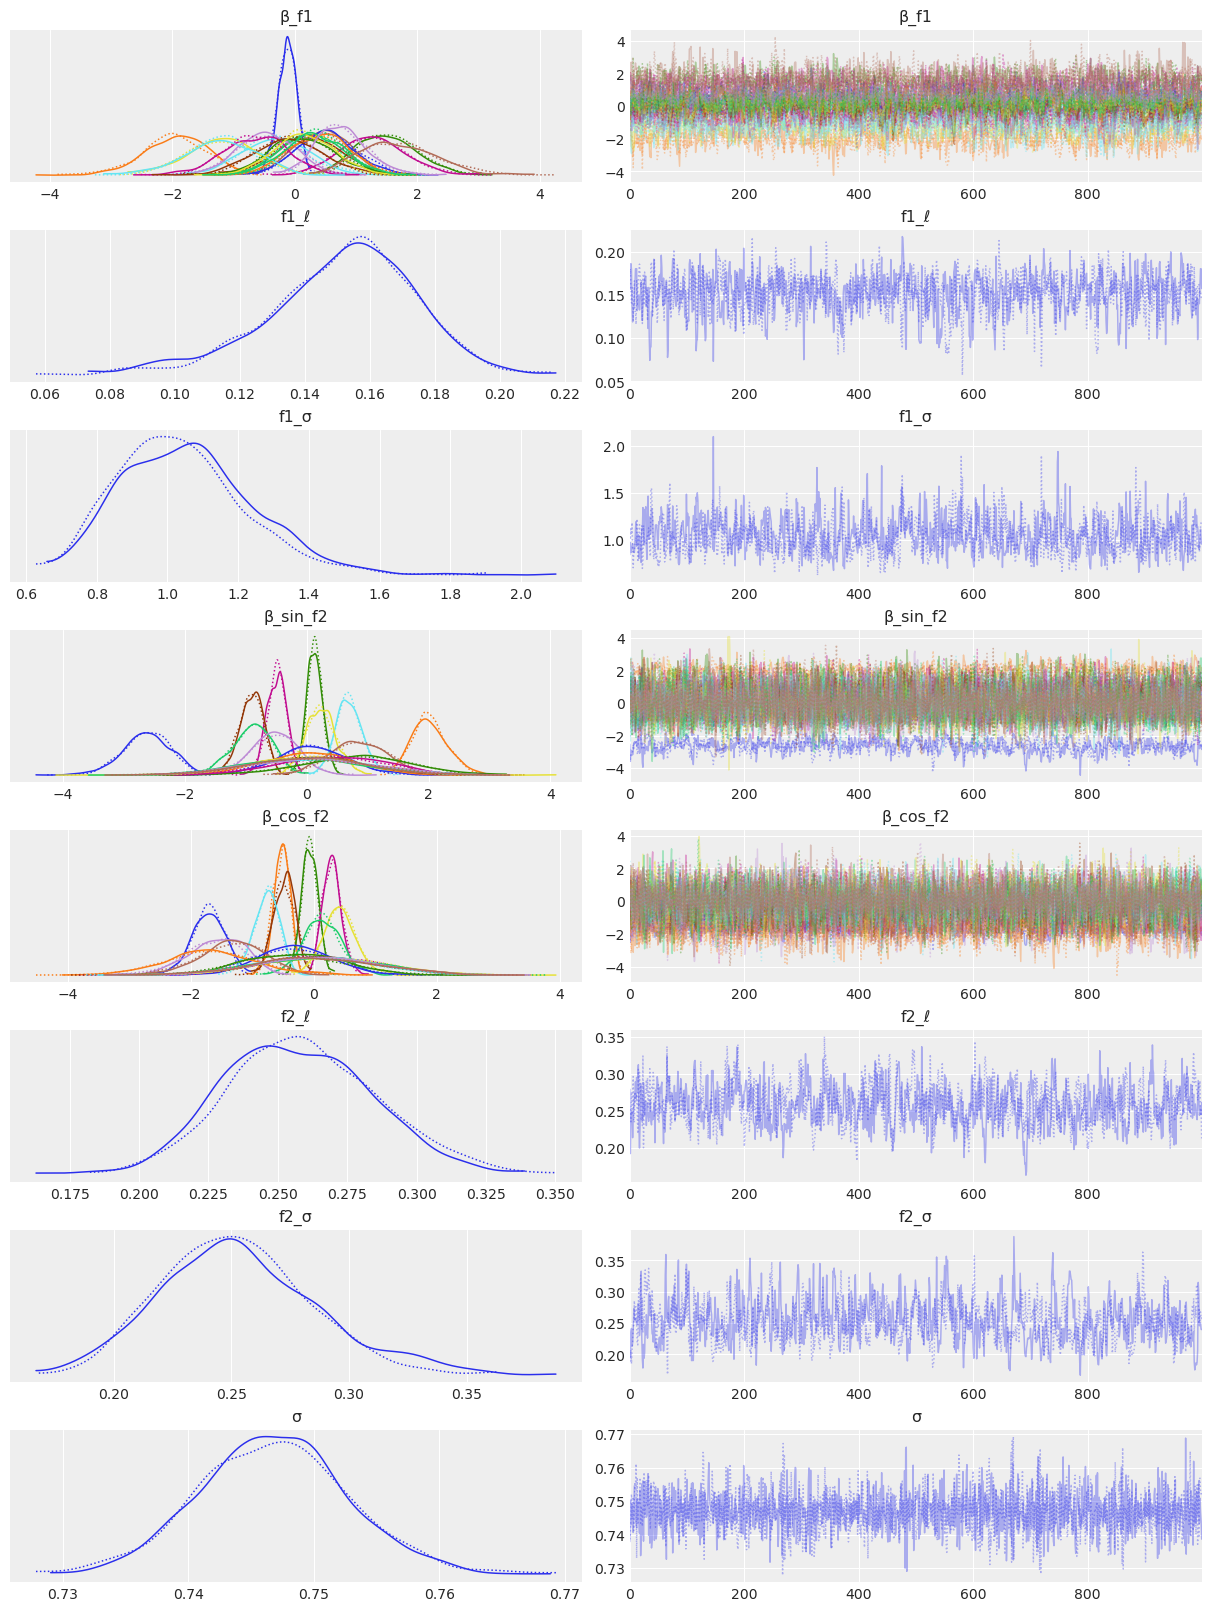

In [26]:
az.plot_trace(idata2, var_names=["β_f1", "f1_ℓ", "f1_σ",  "β_sin_f2", "β_cos_f2", "f2_ℓ", "f2_σ", "σ"]);

In [27]:
y_by_day_of_year = data.groupby("day_of_year2")["births_relative100"].mean()
μ = y_scaler.unscale(idata2.posterior["μ"]).mean(axis=(0, 1))
f1 = y_scaler.unscale(idata2.posterior["f1"]).mean(axis=(0, 1))
f2 = y_scaler.unscale(idata2.posterior["f2"]).mean(axis=(0, 1))

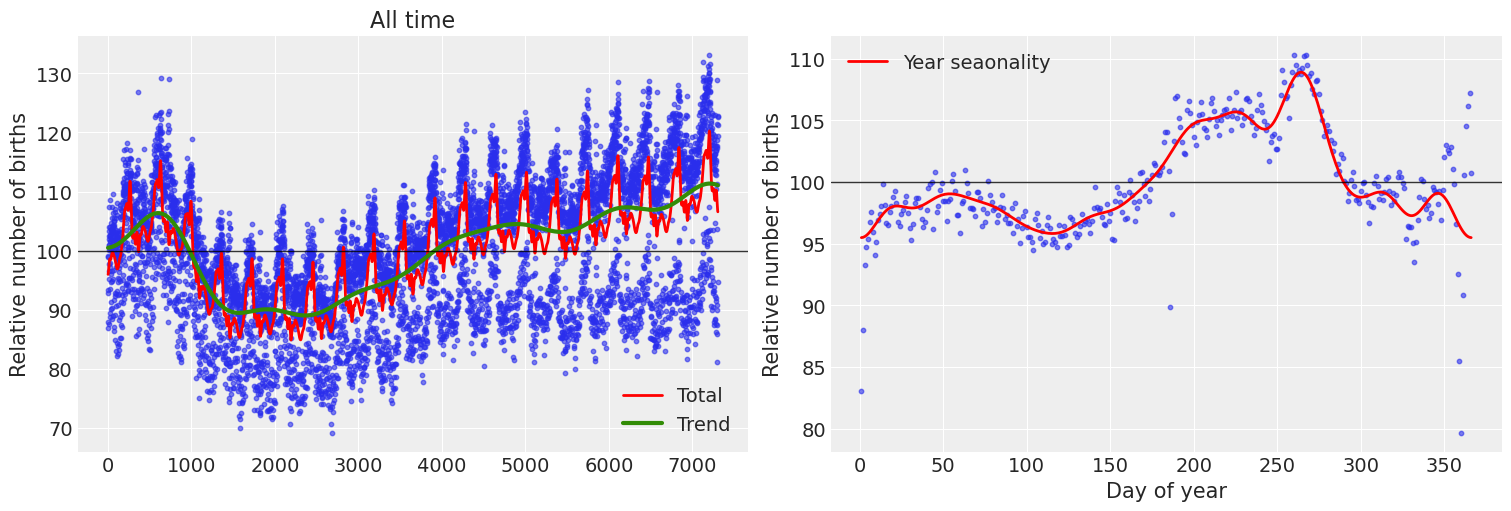

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(x, y, s=10, alpha=0.6)
axes[0].plot(x, μ, color="r", lw=2, alpha=1, label="Total")
axes[0].plot(x, f1, color="C2", lw=3, alpha=1, label="Trend")
axes[0].set_ylabel("Relative number of births")
axes[0].set_title("All time")

axes[1].scatter(y_by_day_of_year.index, y_by_day_of_year, s=10, alpha=0.6)
axes[1].plot(y_by_day_of_year.index, f2[:366], color="r", lw=2, label="Year seaonality")
axes[1].set_ylabel("Relative number of births")
axes[1].set_xlabel("Day of year")

for ax in axes:
    ax.axhline(100, color="k", lw=1, alpha=0.8)
    ax.legend()

## Model 3: Long term smooth + seasonal + weekday with increasing magnitude

Looking at the time series of whole data we see the dots representing the daily values forming three branches that are getting further away from each other. The next model includes time dependent magnitude component for the day of week effect, which allows for a gradual change on the effect for day of week. Aki says they observed that the Saturday and Sunday effect did get stronger in time.


$$
y_i \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i = f_1 + f_2 + \exp(g_3)\beta_{\text{day of week}} \\
f_1 \sim \text{GP}(0, K_1) \\ 
f_2 \sim \text{GP}(0, K_2) \\ 
g_3 \sim \text{GP}(0, K_3) \\
\beta_{\text{day of week}} = 0 \text{ if day is Monday} \\
\beta_{\text{day of week}} \sim \text{Normal}(0, 1) \text{ if day is Monday} \\
\sigma \sim \text{HalfNormal}(0.5)
$$

where 

$$
K_1(x, x') = \sigma_1  \exp\left(-\frac{|x - x'|^2}{2\ell_1^2}\right) \\
\sigma_1 \sim \text{HalfNormal}(0.8) \\
\ell_1 \sim \text{LogNormal}(-1, 1)
$$

<br>

$$
K_2(x, x') = \sigma_2 \exp\left(-\frac{2\sin^2\left(\omega_0 \frac{|x - x'|^2}{2}\right)}{\ell_2^2} \right) \\
\sigma_2 \sim \text{HalfNormal}(0.1) \\
\ell_2 \sim \text{HalfNormal}(1) \\
\omega_0  = \frac{2\pi\text{sd}(x)}{362.25}
$$

<br>


$$
K_3(x, x') = \sigma_3  \exp\left(-\frac{|x - x'|^2}{2\ell_3^2}\right) \\
\sigma_3 \sim \text{HalfNormal}(0.1) \\
\ell_3 \sim \text{LogNormal}(1, 1)
$$

In [29]:
day_of_week = data["day_of_week"].values - 1
L3 = 1.5 * max(x_std)
M3 = 5

with pm.Model() as model_3:
    # Long term trend
    f1_σ = pm.HalfNormal("f1_σ", sigma=0.8)
    f1_ℓ = pm.Lognormal("f1_ℓ", mu=-1, sigma=1)
    k1 = SquaredExponential(f1_σ, f1_ℓ, m1, L1)
    f1 = k1.get_basis("f1", x_std)
    
    # Year-periodic component
    f2_σ = pm.HalfNormal("f2_σ", sigma=0.1)
    f2_ℓ = pm.HalfNormal("f2_ℓ", sigma=1)
    k2 = PeriodicSquaredExponential(f2_σ, f2_ℓ, J2, L2, w0)
    f2 = k2.get_basis("f2", x_std)
    
    # Day of week effect: Monday is set to 0 (baseline)
    β_week = pm.Normal("β_week", 0, 1, shape=6)
    β_week = tt.concatenate([[0], β_week])
    
    g3_σ = pm.HalfNormal("g3_σ", sigma=0.1)
    g3_ℓ = pm.Lognormal("g3_ℓ", 1, 1)
    k3 = SquaredExponential(g3_σ, g3_ℓ, M3, L3)
    g3 = k3.get_basis("g3", x_std)
                             
    μ = pm.Deterministic("μ", f1 + f2 + tt.exp(g3) * β_week[day_of_week])
    σ = pm.HalfNormal("σ", 0.5)
    
    obs = pm.Normal("y", mu=μ, sigma=σ, observed=y_std)

In [30]:
with model_3:
    idata3 = pm.sample(target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β_g3, g3_ℓ, g3_σ, β_week, β_sin_f2, β_cos_f2, f2_ℓ, f2_σ, β_f1, f1_ℓ, f1_σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 668 seconds.
The number of effective samples is smaller than 25% for some parameters.


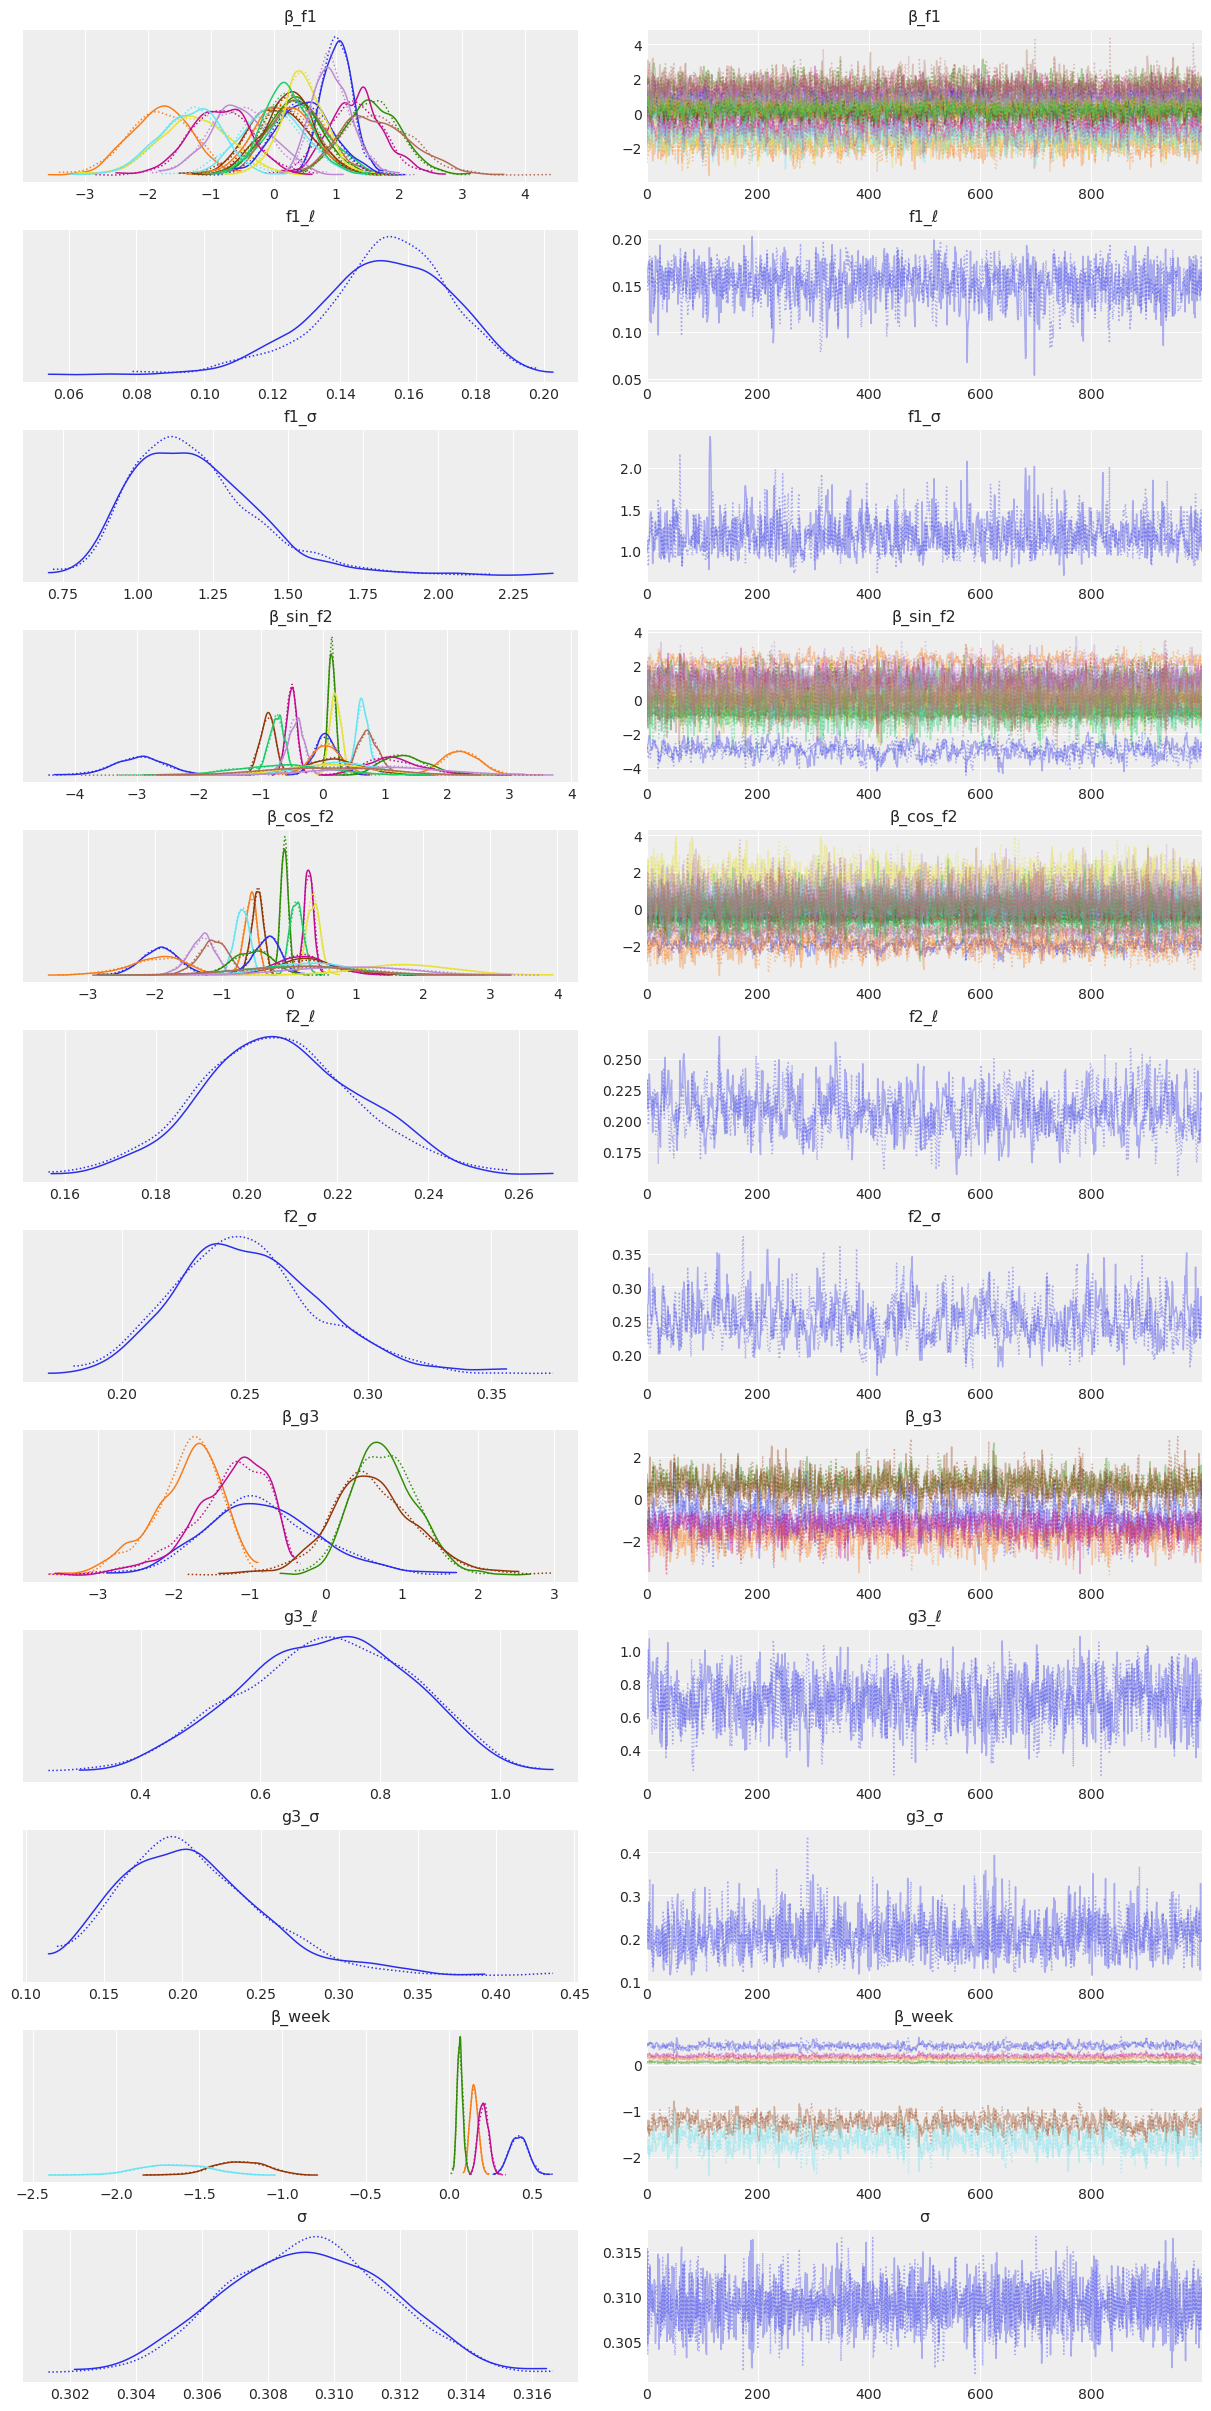

In [31]:
az.plot_trace(
    idata3, 
    var_names=["β_f1", "f1_ℓ", "f1_σ",  "β_sin_f2", "β_cos_f2", "f2_ℓ", "f2_σ", "β_g3", "g3_ℓ", "g3_σ", "β_week", "σ"]
);

No handles with labels found to put in legend.


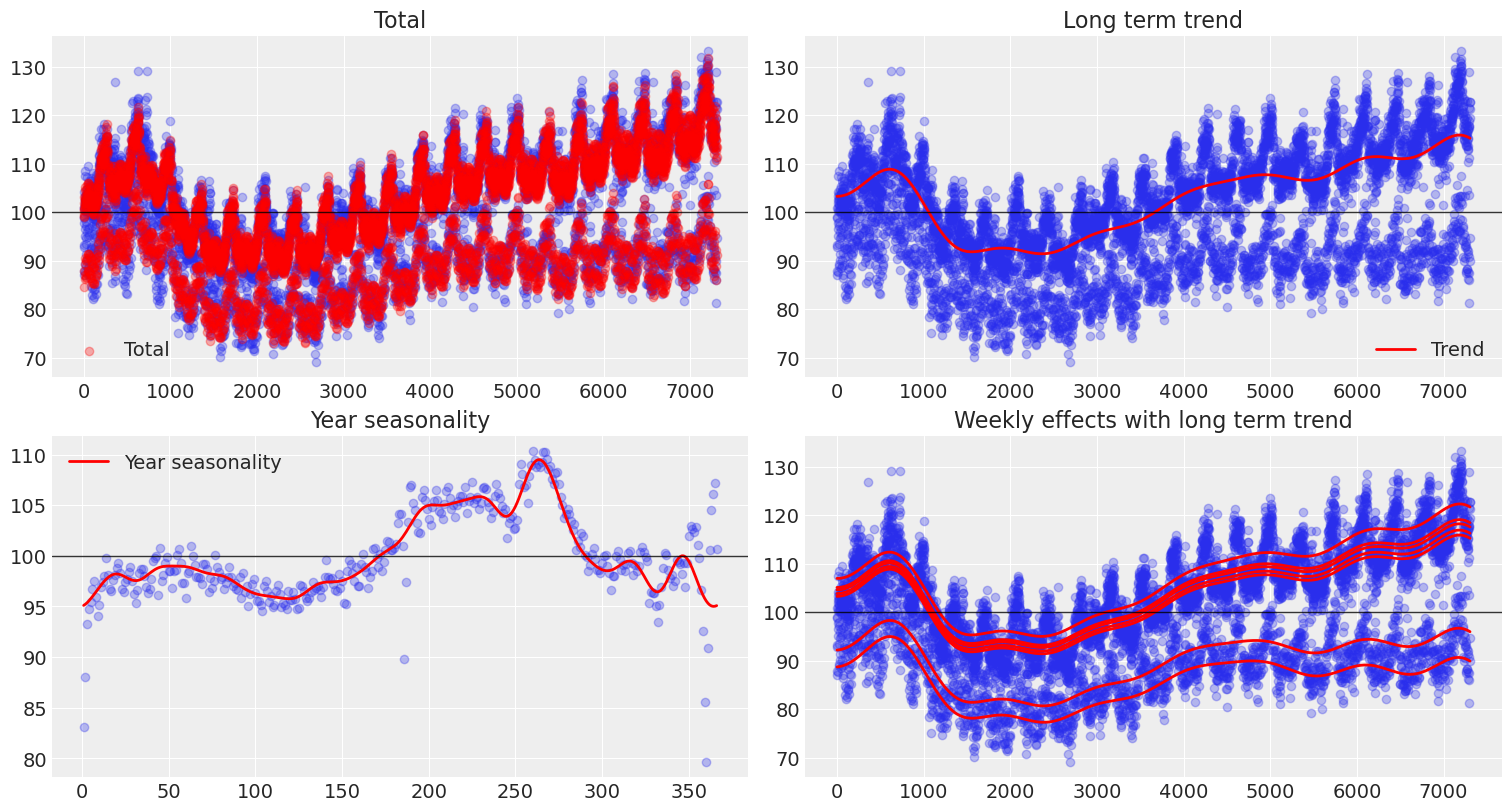

In [36]:
year_days = y_by_day_of_year.index.values

μ = y_scaler.unscale(idata3.posterior["μ"]).mean(axis=(0, 1))

f1_ = idata3.posterior["f1"].values.mean(axis=(0, 1))
f1 = y_scaler.unscale(f1_)

f2_ = idata3.posterior["f2"].values.mean(axis=(0, 1))
f2 = y_scaler.unscale(f2_)

g3 = idata3.posterior["g3"].mean(axis=(0, 1))

β_week = idata3.posterior["β_week"].values.mean(axis=(0, 1))


fig, axes = plt.subplots(2, 2, figsize=(15, 8), sharey=False, sharex=False)
axes[0, 0].scatter(x, y, alpha=0.3)
axes[0, 0].scatter(x, μ, color="r", label="Total", alpha=0.3)

axes[0, 1].scatter(x, y, alpha=0.3)
axes[0, 1].plot(x, f1, color="r", lw=2, label="Trend")

axes[1, 0].scatter(year_days, y_by_day_of_year, alpha=0.3)
axes[1, 0].plot(year_days, f2[:366], color="r", lw=2, label="Year seasonality")

axes[1, 1].scatter(x, y, alpha=0.3)

# Monday
fit = y_scaler.unscale(f1_ + np.exp(g3) * 0)
axes[1, 1].plot(x, fit, lw=2, color="r")

for day in range(6):
    fit = y_scaler.unscale(f1_ + np.exp(g3) * β_week[day])
    axes[1, 1].plot(x, fit, lw=2, color="r")
    
axes[0, 0].set_title("Total")
axes[0, 1].set_title("Long term trend")
axes[1, 0].set_title("Year seasonality")
axes[1, 1].set_title("Weekly effects with long term trend")
for ax in axes.flatten():
    ax.axhline(100, color="k", lw=1, alpha=0.8)
    ax.legend()

## Model 4:

Long term trend with yearly seasonaly, slowly varying day-of-week effect, and special day effect including floating special days.

This is model 8 + RHS in Aki's case study

**STILL NEED TO WRITE THE MODEL**

In [39]:
x = data["id"].values

memorial_days = data.loc[
    data["date"].dt.month.eq(5)
    & data["date"].dt.weekday.eq(0)
    & data["date"].dt.day.ge(25),
    "id",
].values

labour_days = data.loc[
    data["date"].dt.month.eq(9)
    & data["date"].dt.weekday.eq(0)
    & data["date"].dt.day.le(7),
    "id",
].values
labour_days = np.concatenate((labour_days, labour_days + 1))

thanksgiving_days = data.loc[
    data["date"].dt.month.eq(11)
    & data["date"].dt.weekday.eq(3)
    & data["date"].dt.day.ge(22)
    & data["date"].dt.day.le(28),
    "id",
].values
thanksgiving_days = np.concatenate((thanksgiving_days, thanksgiving_days + 1))

memorial_days_indicator = np.zeros_like(x)
memorial_days_indicator[memorial_days - 1] = 1
labour_days_indicator = np.zeros_like(x)
labour_days_indicator[labour_days - 1] = 1
thanksgiving_days_indicator = np.zeros_like(x)
thanksgiving_days_indicator[thanksgiving_days - 1] = 1

In [40]:
day_of_year = data["day_of_year2"].values - 1

L3 = 1.5 * max(x_std)
M3 = 5

with pm.Model() as model_4:
    # Long term trend
    f1_σ = pm.HalfNormal("f1_σ", sigma=0.8)
    f1_ℓ = pm.Lognormal("f1_ℓ", mu=-1, sigma=1)
    k1 = SquaredExponential(f1_σ, f1_ℓ, m1, L1)
    f1 = k1.get_basis("f1", x_std)
    
    # Year-periodic component
    f2_σ = pm.HalfNormal("f2_σ", sigma=0.1)
    f2_ℓ = pm.HalfNormal("f2_ℓ", sigma=1)
    k2 = PeriodicSquaredExponential(f2_σ, f2_ℓ, J2, L2, w0)
    f2 = k2.get_basis("f2", x_std)
    
    # Day of week effect: Monday is set to 0 (baseline)
    β_week = pm.Normal("β_week", 0, 1, shape=6)
    β_week = tt.concatenate([[0], β_week])
    
    g3_σ = pm.HalfNormal("g3_σ", sigma=0.1)
    g3_ℓ = pm.Lognormal("g3_ℓ", 1, 1)
    k3 = SquaredExponential(g3_σ, g3_ℓ, M3, L3)
    g3 = k3.get_basis("g3", x_std)
    
   
    # Horseshoe prior on day of year effect
    # THIS IS THE ORIGINAL, BUT DIDN'T WORK WELL!
    # nu_global = 40     # degrees of freedom for the half-t priors for tau
    #nu_local = 1       # for the regularized horseshoe
    #slab_scale = 2     # for the regularized horseshoe
    #slab_df = 50       # for the regularized horseshoe
    #scale_global=0.1   # global scale for RHS prior
    
    #τ = pm.HalfStudentT("τ", nu_global, scale_global * 2)
    #c_aux = pm.InverseGamma("c_aux", 0.5 * slab_df, 0.5 * slab_df)
    #c = slab_scale * tt.sqrt(c_aux)
    
    #λ = pm.HalfStudentT("λ", nu_local, 1, shape=366)
    #λ_tilde = tt.sqrt(c ** 2 * λ ** 2 / (c ** 2 + τ ** 2 * λ ** 2))
    #β4 = pm.Normal("β4", 0, τ * λ_tilde, shape=366)
    
    # Horseshoe prior based on a blogpost by Austin Rochford
    σ = pm.HalfNormal("σ", 0.5)
    D = 366
    D0 = 12
    
    τ = pm.HalfStudentT("τ", 2, D0 / (D - D0) * σ / np.sqrt(len(x_std)))
    c2 = pm.InverseGamma("c2", 1, 1)
    
    λ = pm.HalfStudentT("λ", 5, shape=D)
    λ_tilde = λ * tt.sqrt(c2 / (c2 + τ ** 2 + λ**2))
    z = pm.Normal("z", 0., 1., shape=D)
    β4 = pm.Deterministic("β4", z * τ * λ_tilde)
    
    # Floating special days
    β5_labour = pm.Normal("β5_labour", 0, 1)
    β5_memorial = pm.Normal("β5_memorial", 0, 1)
    β5_thanksgiving = pm.Normal("β5_thanksgiving", 0, 1)
    
    
    μ = pm.Deterministic(
        "μ", 
        f1 
        + f2 
        + np.exp(g3) * β_week[day_of_week] 
        + β4[day_of_year]
        + β5_labour * labour_days_indicator
        + β5_memorial * memorial_days_indicator
        + β5_thanksgiving * thanksgiving_days_indicator,
    )
    obs = pm.Normal("y", mu=μ, sigma=σ, observed=y_std)

In [41]:
with model_4:
    idata4 = pm.sample(
        draws=600,
        target_accept=0.95, 
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β5_thanksgiving, β5_memorial, β5_labour, z, λ, c2, τ, σ, β_g3, g3_ℓ, g3_σ, β_week, β_sin_f2, β_cos_f2, f2_ℓ, f2_σ, β_f1, f1_ℓ, f1_σ]


Sampling 2 chains for 1_000 tune and 600 draw iterations (2_000 + 1_200 draws total) took 1129 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


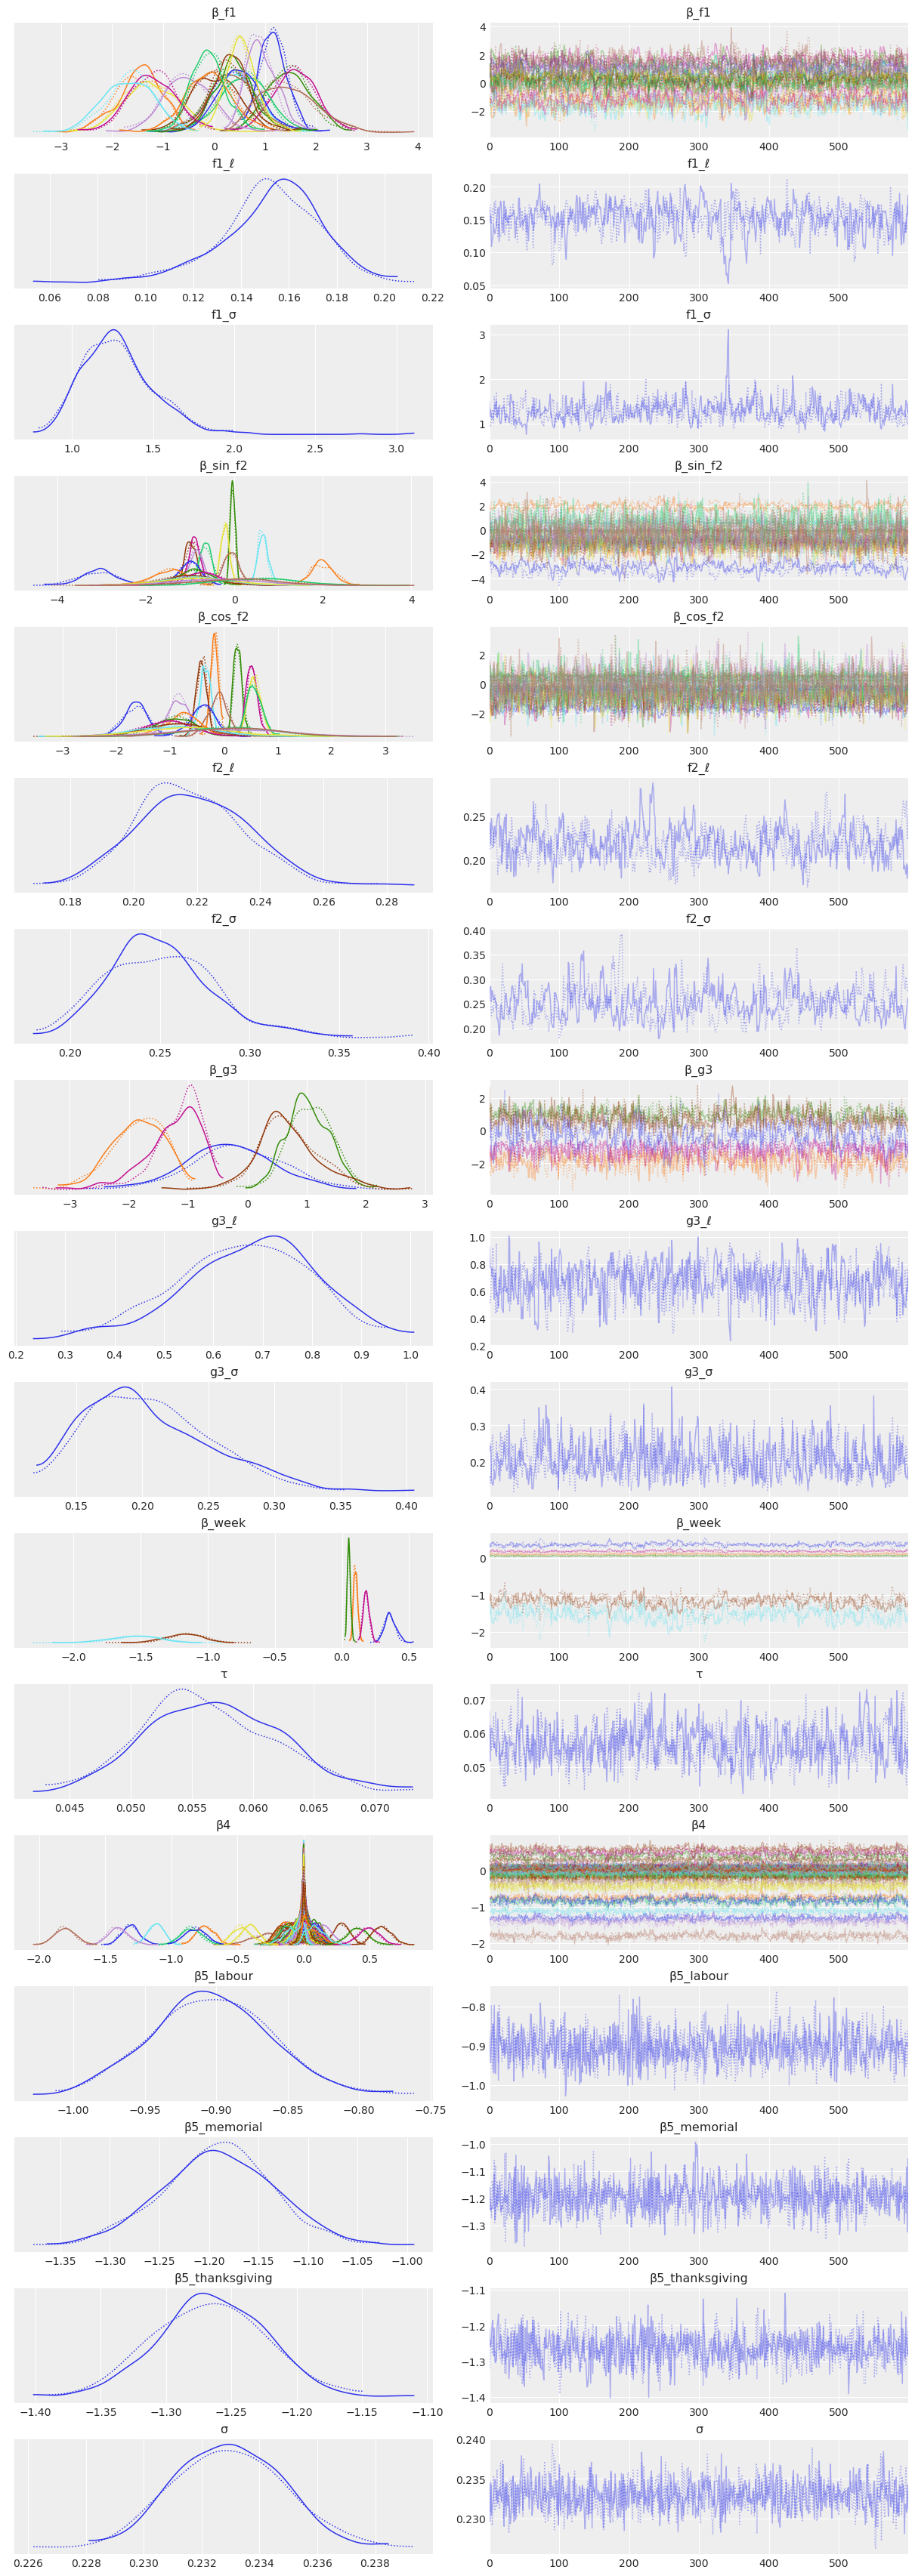

In [44]:
az.plot_trace(
    idata4, 
    var_names=[
        "β_f1", "f1_ℓ", "f1_σ",  
        "β_sin_f2", "β_cos_f2", "f2_ℓ", "f2_σ", 
        "β_g3", "g3_ℓ", "g3_σ", 
        "β_week", 
        "τ", "β4",
        "β5_labour", "β5_memorial", "β5_thanksgiving",
        "σ"
    ]
);

In [47]:
special_days = {
    "Valentine's": pd.to_datetime("1988-02-14"),
    "Leap day": pd.to_datetime("1988-02-29"),
    "Halloween": pd.to_datetime("1988-10-31"),
    "Christmas eve": pd.to_datetime("1988-12-24"),
    "Christmas day": pd.to_datetime("1988-12-25"),
    "New year": pd.to_datetime("1988-01-01"),
    "New year's eve": pd.to_datetime("1988-12-31"),
    "April 1st": pd.to_datetime("1988-04-01"),
    "Independence day": pd.to_datetime("1988-07-04"),
    "Labour day": pd.to_datetime("1988-09-05"),
    "Memorial day": pd.to_datetime("1988-05-30"),
    "Thanksgiving": pd.to_datetime("1988-11-24"),
}

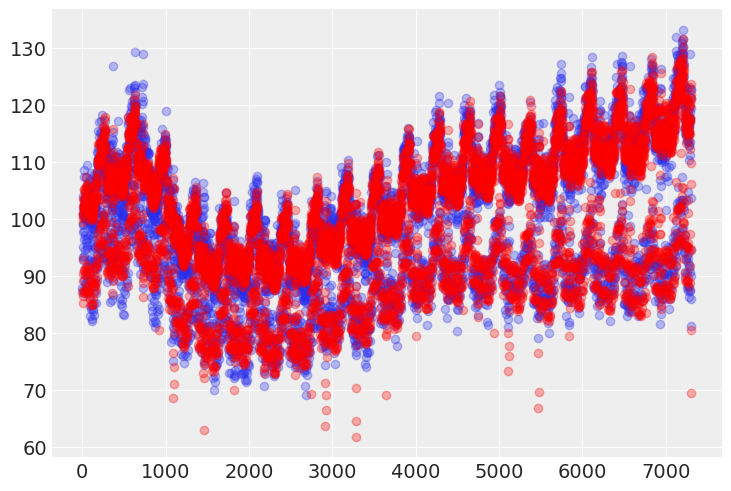

In [45]:
μ = y_scaler.unscale(idata4.posterior["μ"]).mean(axis=(0, 1))
plt.scatter(x, y, alpha=0.3)
plt.scatter(x, μ, color="r", label="Total", alpha=0.3);

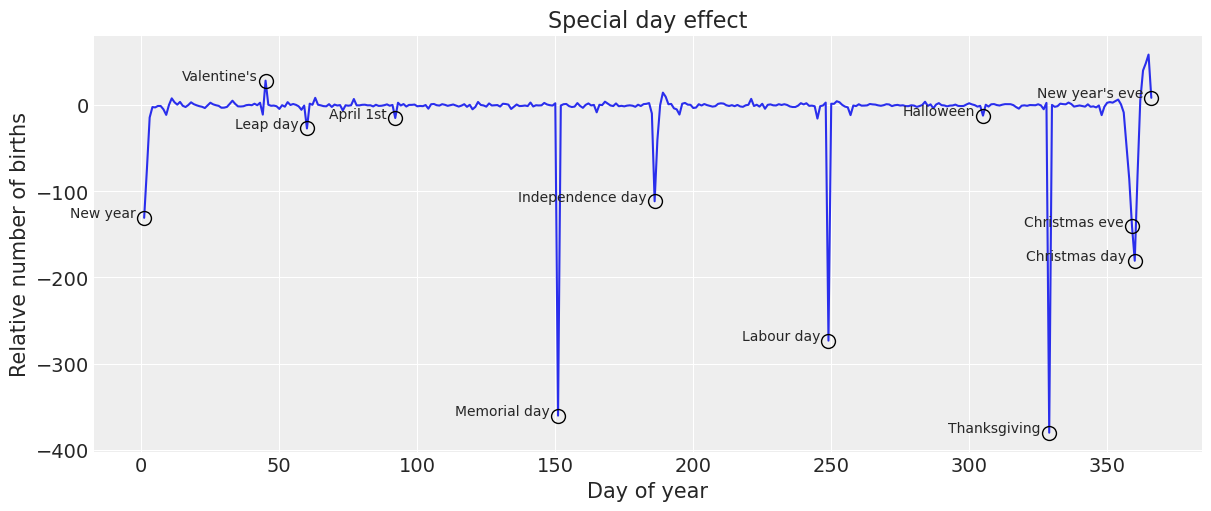

In [50]:
β4 = idata4.posterior["β4"].values
β5_labour = idata4.posterior["β5_labour"].values
β5_memorial = idata4.posterior["β5_memorial"].values
β5_thanksgiving = idata4.posterior["β5_thanksgiving"].values

day_effect = β4
md_idx = special_days["Memorial day"].day_of_year - 1
day_effect[:, :, md_idx] = day_effect[:, :, md_idx] + β5_memorial
ld_idx = special_days["Labour day"].day_of_year - 1
day_effect[:, :, ld_idx] = day_effect[:, :, ld_idx] + β5_labour
td_idx = special_days["Thanksgiving"].day_of_year - 1
day_effect[:, :, td_idx] = day_effect[:, :, td_idx] + β5_thanksgiving
day_effect = 100 * day_effect.mean(axis=0)

fig = plt.figure(figsize=(12, 5))
plt.plot(np.arange(1, 367), day_effect.mean(0))

for name, day in special_days.items():
    xs = day.day_of_year
    ys = day_effect.mean(0)[day.day_of_year - 1]
    plt.plot(xs, ys, marker="o", mec="k", c="none", ms=10)
    plt.text(xs - 3, ys, name, horizontalalignment="right")
    
plt.title("Special day effect")
plt.ylabel("Relative number of births")
plt.xlabel("Day of year");